This notebook applied synthetic travel dataset, simulating real corporate travel agency with flights and hotels. The analysis process are divided into three parts:

First part - An overview of the company's sales to shape the business question.  
Second part - Transform the dataframe from flight ticket order dimension to customer dimension.  
Third part - Find which features are most related to the travel agency's churned customer.

### Table of contents 
<a id="Z"></a>
* [Part I - Company Overview](#A)
    - [Import Libaries and Load Data](#a1)
    - [Check df_user](#a2)
    - [Check df_flight](#a3)
    - [Picture Business Scope](#a4)
    - [Check df_hotel](#a5)
    - [Relationship of Flight and Hotel](#a6)    
    
    
* [Part II - Transform Dataframe](#B)
    - [Combine the Round Tickets into One Record](#b1)
    - [Join Flight Record with Hotel Record](#b2)
    - [Transform from Order Dimension to Customer Dimension](#b3)  
    
    
* [Part III -  Predict Customer Churn](#C)
    - [Create Dataset for Machine Learning](#c1)
    - [Visualize the Distribution of Features](#c2)
    - [Undersampling](#c3)
    - [Setup Features for Model Training](#c4)
    - [Model I - Naive Bayes](#c5)
    - [Model II - XGB](#c6)
    - [Scatterplot Matrix for Significant Features](#c7)
    - [Model III - Logistic Regression](#c8)
    - [Regression Plot for Possible Factors](#c9)
    - [Compare the Prediction Result of Models](#c10)
    
    
<a id="Z"></a>

## Part I - Company Overview <a id="A"></a>

### Import Libaries and Load Data
<a id="a1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))     
# undersampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from matplotlib import cm
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
#XGB
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, average_precision_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix,classification_report

/kaggle/input/argodatathon2019/users.csv
/kaggle/input/argodatathon2019/hotels.csv
/kaggle/input/argodatathon2019/flights.csv


In [2]:
df_user = pd.read_csv('/kaggle/input/argodatathon2019/users.csv')
df_hotel = pd.read_csv('/kaggle/input/argodatathon2019/hotels.csv')
df_flight = pd.read_csv('/kaggle/input/argodatathon2019/flights.csv')

[RETURN TO TOP](#Z)

### Check df_user
<a id="a2"></a>

In [3]:
df_user.isnull().sum()

code       0
company    0
name       0
gender     0
age        0
dtype: int64

In [4]:
df_user.head()

,code,company,name,gender,age
0,0,4You,Roy Braun,male,21
1,1,4You,Joseph Holsten,male,37
2,2,4You,Wilma Mcinnis,female,48
3,3,4You,Paula Daniel,female,23
4,4,4You,Patricia Carson,female,44


In [5]:
df_user.groupby("company").size()

company
4You             453
Acme Factory     261
Monsters CYA     195
Umbrella LTDA    194
Wonka Company    237
dtype: int64

The agency cooperates with four companies. 4 You is the biggest partner of the agency, which has 453 customers. This information can be kept in mind.

In [6]:
df_user.groupby("gender").size()

gender
female    448
male      452
none      440
dtype: int64

Female and male are eqaul amount and there is 'none' type in gender. As 30% of the attribute is rather incomplete, it's preferable to exclude it in the later analysis.

In [7]:
# df_user['ageRange'] = pd.cut(df_user.age, [20,30,40,50,60,65])
# df_user.groupby("ageRange").size()

[RETURN TO TOP](#Z)

### Check df_flight
<a id="a3"></a>

In [8]:
df_flight.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019


In [9]:
df_flight.groupby("agency").size()

agency
CloudFy        116378
FlyingDrops     38758
Rainbow        116752
dtype: int64

The agency cooperates with three airlines. FlyingDrops seems to have the least flight for the travellers.

In [10]:
df_flight.groupby(['travelCode', 'userCode']).size().max()

2

In [11]:
df_flight.groupby(['travelCode', 'userCode']).size().min()

2

A travelCode is always paired with two userCode. It indicates that all the bookings are round trips.

In [12]:
# Preprocess the form of datatime
df_flight["datetime"] = pd.to_datetime(df_flight["date"])
df_flight['monthYear'] = pd.to_datetime(df_flight['datetime']).dt.to_period('M')
df_flight['year'] = pd.to_datetime(df_flight['datetime']).dt.year
df_flight['month'] = pd.to_datetime(df_flight['datetime']).dt.month

In [13]:
print("The dataset ranges from ",df_flight["datetime"].min(),"to", df_flight["datetime"].max())

The dataset ranges from  2019-09-26 00:00:00 to 2023-07-24 00:00:00


[RETURN TO TOP](#Z)

### Picture Business Scope
<a id="a4"></a>

In [14]:
# Group by month and Sum the price
df_month_grow_rate = df_flight.groupby('monthYear')["price"].sum().to_frame()
# Drop 2019-09 fror its data is not completed
df_month_grow_rate  = df_month_grow_rate .iloc[1: , :]
# Lag the last price row to the next one 
df_month_grow_rate['lastMonthPrice'] = df_month_grow_rate['price'].shift(periods=1)
# Calculate the month growth rate
df_month_grow_rate['monthGrowthRate'] = (df_month_grow_rate['price']-df_month_grow_rate['lastMonthPrice'])/df_month_grow_rate['lastMonthPrice']
# Roud up the decimal
df_month_grow_rate['MoM(%)'] = round((df_month_grow_rate['monthGrowthRate']),3) * 100 
# Reset index in the dataframe
df_month_grow_rate = df_month_grow_rate .reset_index()
df_month_grow_rate['MoM(%)'] = round(round((df_month_grow_rate['monthGrowthRate']),3) *100,2)
df_month_grow_rate['monthYearInt'] = df_month_grow_rate['monthYear'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

[Text(0.5, 0, 'Year/Month'), Text(0, 0.5, 'MoM(%)')]

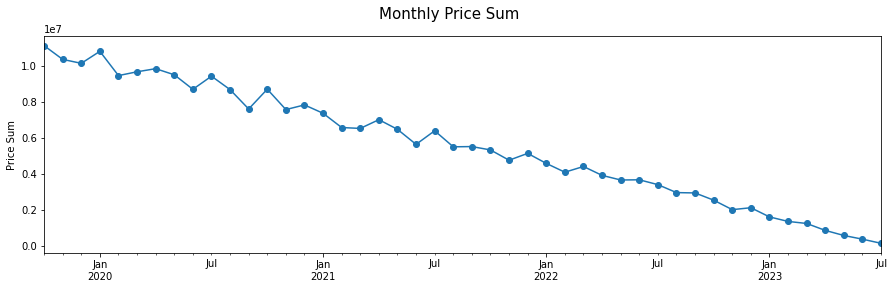

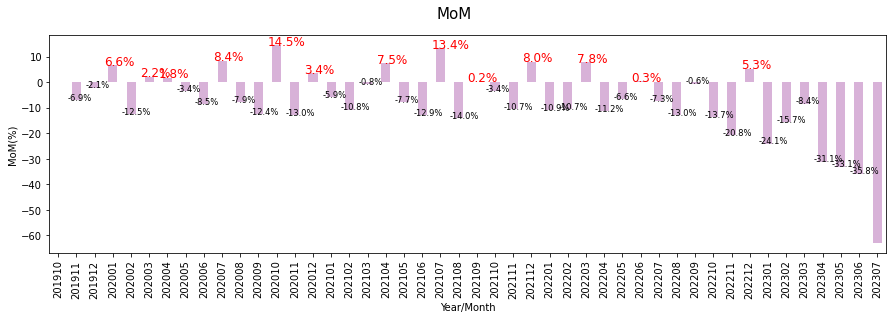

In [15]:
fig1, ax1 = plt.subplots(figsize=(15, 4))
fig2, ax2 = plt.subplots(figsize=(15, 4))
# ax2=axs.twinx()
df_month_grow_rate.groupby('monthYear')["price"].sum().plot(kind='line', ax=ax1, marker="o")
df_month_grow_rate.groupby('monthYearInt')["MoM(%)"].sum().plot(
    kind='bar', ax=ax2,color="purple", alpha=0.3, label=True)

for a, b, in zip(range(45),df_month_grow_rate["MoM(%)"]):
    if b < 0:
        plt.text(a-0.5, b, str(b) + '%', rotation=0, fontsize='small')
    if b > 0:
        plt.text(a-0.5, b, str(b) + '%', rotation=0, fontsize='large', c = 'red')
    
fig1.suptitle('Monthly Price Sum', fontsize = '15')
fig2.suptitle('MoM', fontsize = '15')

ax1.set(xlabel=' ', ylabel='Price Sum')
ax2.set(xlabel='Year/Month', ylabel='MoM(%)')

The sum of the price decreases each month since 2019 October. Seasonally on spring (Dec & Jan) and summer (July) the price will spike 8% to 10%. The traval agency might aim at the holiday seasons.
Also, it's interesting to know why the customers drop so quickly. Thus, in the later analysis, it's critical to zoom in the comparison of "2019 Oct - 2020 Sep" and "2020 Oct - 2021 Sep" data to investigate the early signs when the travel agency was about to lose the customer.

Sadly to say, the synthetic data might tell the story of how a small travel agency scaled down with the occurrence of the Covid-19. 

In [16]:
df_flight_data = df_flight.loc[(df_flight['monthYear'] >= '2019-10') & (df_flight['monthYear'] <= '2021-09')]
data = df_flight_data.groupby(['year','monthYear','month'], as_index=False)['price'].sum()
data['index'] = [1,2,3,4,5,6,7,8,9,10,11,12,1,2,3,4,5,6,7,8,9,10,11,12]
data['group'] = ['A','A','A','A','A','A','A','A','A','A','A','A','B','B','B','B','B','B','B','B','B','B','B','B']

In [17]:
data.head()

,year,monthYear,month,price,index,group
0,2019,2019-10,10,11114297.46,1,A
1,2019,2019-11,11,10351126.08,2,A
2,2019,2019-12,12,10131735.82,3,A
3,2020,2020-01,1,10798562.51,4,A
4,2020,2020-02,2,9451488.23,5,A


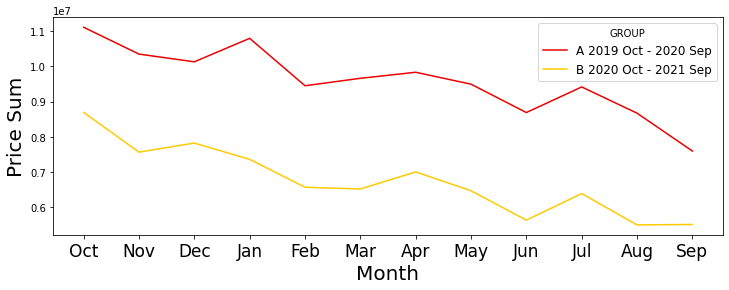

In [18]:
fig, axs = plt.subplots(figsize=(12, 4))
sns.lineplot(data=data, x='index', y='price', hue='group',markers= ["o","<"],palette = 'hot')
axs.set_xticks(range(1,13))
axs.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep'],fontsize = 17)
axs.set_xlabel("Month", fontsize = 20)
axs.set_ylabel("Price Sum", fontsize = 20)
plt.legend(title='GROUP', loc='upper right', labels=['A 2019 Oct - 2020 Sep', 'B 2020 Oct - 2021 Sep'],fontsize = 12)
plt.show()

Generally the revenue falls down. Group A and Group B have similar pattern that Dec/Jan and July are the peak.  
One possible reason is that in the three specific months, there are more vacations.
In the following analysis, we scaled down the data within Group A and B.  

The big question is: Why did Group B (2020-2021) has lower revenue each month, comparing to Group A (2019-2020)?

- What's the percentage of new customers?
- How did the customers travel? Did they book hotel with flights? Did they unsatisified with the services?
- Which features are more related to customer retention? Which group of customers decided not to travel first?


[RETURN TO TOP](#Z)

### Check df_hotel
<a id="a5"></a>

In [19]:
# Preprocess the form of datatime
df_hotel["datetime"] = pd.to_datetime(df_hotel["date"])
df_hotel['monthYear'] = pd.to_datetime(df_hotel['datetime']).dt.to_period('M')
df_hotel['year'] = pd.to_datetime(df_hotel['datetime']).dt.year
df_hotel['month'] = pd.to_datetime(df_hotel['datetime']).dt.month

In [20]:
df_hotel.head()

,travelCode,userCode,name,place,days,price,total,date,datetime,monthYear,year,month
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,09/26/2019,2019-09-26,2019-09,2019,9
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,10/10/2019,2019-10-10,2019-10,2019,10
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,11/14/2019,2019-11-14,2019-11,2019,11
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,12/12/2019,2019-12-12,2019-12,2019,12
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,12/26/2019,2019-12-26,2019-12,2019,12


In [21]:
df_hotel.isnull().sum()

travelCode    0
userCode      0
name          0
place         0
days          0
price         0
total         0
date          0
datetime      0
monthYear     0
year          0
month         0
dtype: int64

In [22]:
df_flight.groupby("to").size()

to
Aracaju (SE)           37224
Brasilia (DF)          30779
Campo Grande (MS)      34748
Florianopolis (SC)     57317
Natal (RN)             23796
Recife (PE)            30480
Rio de Janeiro (RJ)    16815
Salvador (BH)          17104
Sao Paulo (SP)         23625
dtype: int64

In [23]:
df_hotel.groupby(['name', 'place']).size()

name      place              
Hotel A   Florianopolis (SC)     3330
Hotel AF  Sao Paulo (SP)         4828
Hotel AU  Recife (PE)            4467
Hotel BD  Natal (RN)             4829
Hotel BP  Brasilia (DF)          4437
Hotel BW  Campo Grande (MS)      4333
Hotel CB  Rio de Janeiro (RJ)    5029
Hotel K   Salvador (BH)          5094
Hotel Z   Aracaju (SE)           4205
dtype: int64

The travel agency has 9 corperate hotels, each hotel locates in a separate city without duplicate.
The 9 cities are the same as the destination of the flights. Each city has one cooperate hotel. While the travel agency is scaling up their business, it's important to take account of the quality of 3 agencies and 9 hotels. Thus, I'll probe on its business strategy if Flight + Hotel combo is a good choice.

- Considering the travel agency's service, did the customers who book Flight + Hotel combo more often book the next trip?



[RETURN TO TOP](#Z)

### Relationship of Flight and Hotel
<a id="a6"></a>

In [24]:
# Frame the dataset
df_flight = df_flight.loc[(df_flight['monthYear'] >= '2019-10') & (df_flight['monthYear'] <= '2021-09')]
df_hotel = df_hotel.loc[(df_hotel['monthYear'] >= '2019-10') & (df_hotel['monthYear'] <= '2021-09')]

In [25]:
df_flight_groupby = df_flight.groupby('monthYear')["price"].sum().to_frame()
df_hotel_groupby = df_hotel.groupby('monthYear')["price"].sum().to_frame()
df_flight_hotel = pd.merge(df_flight_groupby, df_hotel_groupby, on=['monthYear'], how='left')
df_flight_hotel = df_flight_hotel.rename(columns={'price_x': 'flightPrice', 'price_y': 'hotelPrice'})

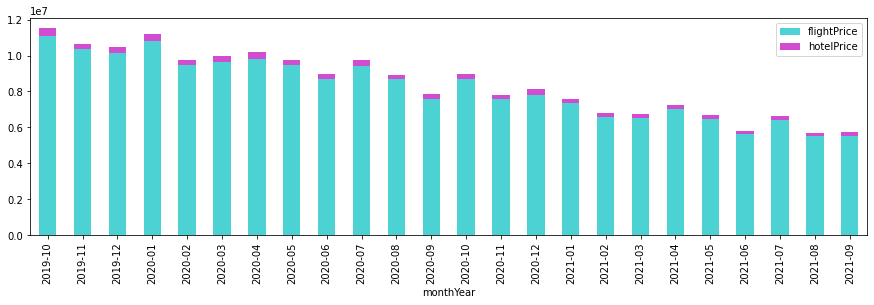

In [26]:
ax = df_flight_hotel.plot.bar(stacked=True,figsize=(15, 4),color=['c','m'],alpha=0.7)

The travel agency's core business is booking the flight. Hotel is not their main focused. Have a good hotel with reasonable price can attract more business. However, it is also risky that the hotel experience might ruin the travel and the prestige of the travel agency. Observing the percentage of hotel revenue, the finding is that the agency hasn't expand the cooperation with the hotels through out the years. Maybe the accomondation of hotel rooms (supply) are limited or the need is not created. All in all, it's important to further investigate the performance of flight + hotel combo. Eventually for the existed customers, is it a plus or minus?

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


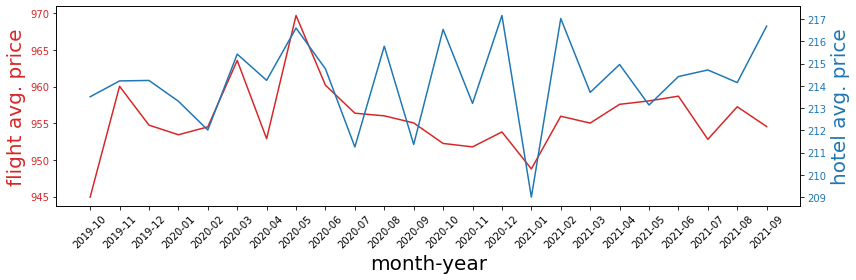

In [27]:
a = df_hotel["monthYear"].astype(str).to_numpy()
a = np.unique(a)
t = a

data1 = df_flight.groupby(df_flight["datetime"].dt.to_period('M'))["price"].mean().to_numpy()
data2 = df_hotel.groupby(df_hotel["datetime"].dt.to_period('M'))["price"].mean().to_numpy()

fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.set_xlabel('month-year', fontsize = 20)
ax1.set_xticklabels(a,fontsize = 10, rotation = 45 )


color = 'tab:red'
ax1.set_ylabel('flight avg. price', color=color, fontsize = 20)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('hotel avg. price', color=color, fontsize = 20)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()




The average price of flight is more stable than the hotel, while hotel average price falls in Jan. 2021 as a gap. Probably there is a promotion of hotel in the non-holiday season (the discount is around 6 dollars) as well as the promotion of flight (the discount is around 5 dollars). However, remember the peak of price sum also happends on January? It's more likely that there are business trips after the holidays and the agency chooses to give discount to the customers which successfully warms up the travel business.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


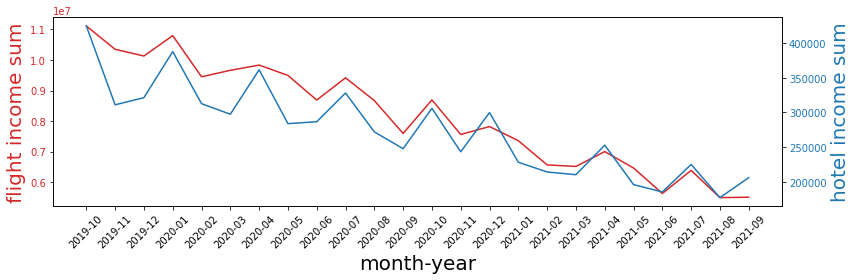

In [28]:
a = df_hotel["monthYear"].astype(str).to_numpy()
a = np.unique(a)
t = a

data1 = df_flight.groupby(df_flight["datetime"].dt.to_period('M'))["price"].sum().to_numpy()
data2 = df_hotel.groupby(df_hotel["datetime"].dt.to_period('M'))["price"].sum().to_numpy()

fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.set_xlabel('month-year', fontsize = 20)
ax1.set_xticklabels(a,fontsize = 10, rotation = 45 )


color = 'tab:red'
ax1.set_ylabel('flight income sum', color=color, fontsize = 20)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('hotel income sum', color=color, fontsize = 20)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As dicovered before, there are seasonally up and down in flight and hotel total income. Hotel revenue is aligned with flight revenue, indicating that the market of flight + hotel combo are sustainable. There is a group of customers who booked them insistantly. Whenever there is a flight, there is the need for hotel.

[RETURN TO TOP](#Z)

## Part II - Transform Dataframe
<a id="B"></a>
### Combine the Round Tickets into One Record
<a id="b1"></a>


In [29]:
 df_flight_combine = df_flight
# Take return ticket's price and date 
df_flight_combine['price_return'] = (df_flight_combine.groupby(['travelCode','userCode'])['price'].shift(-1))
df_flight_combine['date_return'] = (df_flight_combine.groupby(['travelCode','userCode'])['date'].shift(-1))
df_flight_combine["datetime_return"] = pd.to_datetime(df_flight_combine["date_return"])
# Drop one of the combined columns
df_flight_combine = df_flight_combine.dropna(how='any',axis=0)
# Calculate travel date
df_flight_combine['travel_date'] = df_flight_combine.datetime_return - df_flight_combine.datetime
# Extract integer from travel date
df_flight_combine['travel_date_int'] = df_flight_combine['travel_date'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [30]:
df_flight_combine.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date,datetime,monthYear,year,month,price_return,date_return,datetime_return,travel_date,travel_date_int
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019,2019-10-03,2019-10,2019,10,1127.36,10/04/2019,2019-10-04,1 days,1
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019,2019-10-10,2019-10,2019,10,1531.92,10/12/2019,2019-10-12,2 days,2
6,3,0,Aracaju (SE),Campo Grande (MS),economic,743.54,1.69,650.10,Rainbow,10/17/2019,2019-10-17,2019-10,2019,10,877.56,10/20/2019,2019-10-20,3 days,3
8,4,0,Recife (PE),Florianopolis (SC),economic,803.39,1.76,676.53,Rainbow,10/24/2019,2019-10-24,2019-10,2019,10,695.30,10/26/2019,2019-10-26,2 days,2
10,5,0,Brasilia (DF),Aracaju (SE),firstClass,1287.52,1.11,425.98,FlyingDrops,10/31/2019,2019-10-31,2019-10,2019,10,898.04,11/01/2019,2019-11-01,1 days,1


[RETURN TO TOP](#Z)

### Join Flight Record with Hotel Record
<a id="b2"></a>

In [31]:
# Join round trip information with hotel information
# Take the needed information from hotel dataframe and create new dataframe
# Rename the columns in case misunderstanding
df_hotel_join = df_hotel.rename(columns={'name': 'name_hotel', 'days': 'days_hotel', 'total': 'total_hotel'})
df_hotel_join = df_hotel_join[['travelCode', 'userCode','name_hotel','days_hotel','total_hotel']]
# Left join the round flight and hotel
df_flight_hotel = pd.merge(df_flight_combine, df_hotel_join, on=['travelCode', 'userCode'], how='left')
# Create bundle column to distinguish the travller who booked flight and hotel together
df_flight_hotel['combo'] = 0
df_flight_hotel['combo'] [df_flight_hotel['total_hotel']>0] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [32]:
df_flight_hotel.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date,...,month,price_return,date_return,datetime_return,travel_date,travel_date_int,name_hotel,days_hotel,total_hotel,combo
0,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019,...,10,1127.36,10/04/2019,2019-10-04,1 days,1,NaN,NaN,NaN,0
1,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019,...,10,1531.92,10/12/2019,2019-10-12,2 days,2,Hotel K,2.0,526.82,1
2,3,0,Aracaju (SE),Campo Grande (MS),economic,743.54,1.69,650.10,Rainbow,10/17/2019,...,10,877.56,10/20/2019,2019-10-20,3 days,3,NaN,NaN,NaN,0
3,4,0,Recife (PE),Florianopolis (SC),economic,803.39,1.76,676.53,Rainbow,10/24/2019,...,10,695.30,10/26/2019,2019-10-26,2 days,2,NaN,NaN,NaN,0
4,5,0,Brasilia (DF),Aracaju (SE),firstClass,1287.52,1.11,425.98,FlyingDrops,10/31/2019,...,10,898.04,11/01/2019,2019-11-01,1 days,1,NaN,NaN,NaN,0


In [33]:
df_flight_hotel.groupby(['combo']).size()

combo
0    71797
1    30550
dtype: int64

Nearly 30% of the customers will choose flight and hotel combo. However, there are still space to improve.

<AxesSubplot:title={'center':'How often did the users book combo?'}, xlabel='count of combo', ylabel='count of user'>

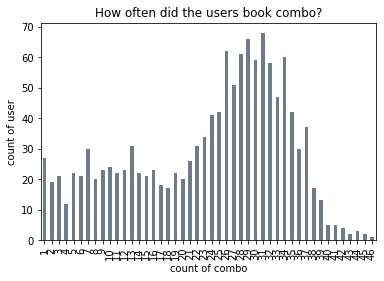

In [34]:
df_combo_count = df_flight_hotel.groupby(['combo','userCode']).size()
df_combo_count = df_combo_count.to_frame('count')
df_combo_count = df_combo_count.loc[1]
df_combo_count = df_combo_count.groupby('count').size()
df_combo_count = df_combo_count.to_frame('combo count')
df_combo_count.plot.bar(legend=None, color = '#6D7B8D', title = 'How often did the users book combo?'
                        , xlabel = 'count of combo', ylabel = 'count of user')



From the bar chart, it clarifies that if the user has booked the flight+hotel combo, only about 30 users booked only once. That is, there is a big chance that once the travellers choose combo package, they would keep the habit for their next journey. The quality of the combo might not be a concern.

<AxesSubplot:>

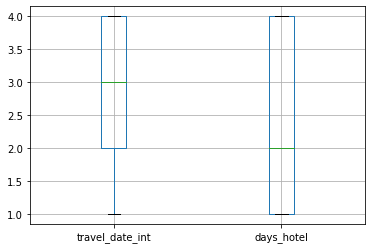

In [35]:
df_flight_hotel.boxplot(column=['travel_date_int','days_hotel'])

The users travel averagely 3 days.

In [36]:
df_flight_hotel.groupby(['days_hotel']).size()

days_hotel
1.0    7649
2.0    7659
3.0    7603
4.0    7639
dtype: int64

No matter long trips (four nights) or short trips (one night), the users have the same tendency to book the hotel. 

[RETURN TO TOP](#Z)

### Transform from Order Dimension to Customer Dimension
<a id="b3"></a>
Find out how many users book the flight since 2019-Oct, as well as who join as new customers on 2020-Oct.

In [37]:
df_churned = df_flight_hotel

In [38]:
# If it is the agency's first year order (since 2019/10~2020/09) then label it as old order.
conditions = [(df_churned['datetime'] >= '10/01/2019') &  (df_churned['datetime'] <= '09/30/2020')]
df_churned['orderOld'] = np.select(conditions, '1', default='0')
# If it is the agency's second year order (since 2020/10~2021/09) then label it as new order.
conditions = [(df_churned['datetime'] >= '10/01/2020') &  (df_churned['datetime'] <= '09/30/2021')]
df_churned['orderNew'] = np.select(conditions, '1', default='0')
# Str to Int
df_churned['orderNew']=df_churned['orderNew'].astype(int)
df_churned['orderOld']=df_churned['orderOld'].astype(int)

In [39]:
# Group by the users to calculate how many old orders and new orders if person has each.
df_churned_groupby = df_churned.groupby(['userCode']).sum()
# Reset the index
df_churned_groupby = df_churned_groupby.reset_index()
# Add a new column to calculate the old and new orders in total.
df_churned_groupby['orderSum'] = df_churned_groupby['orderNew'] + df_churned_groupby['orderOld']

In [40]:
# Categorized customer status into "new","continued", "churned"
df_churned_groupby['userStatus'] = 0
df_churned_groupby['userStatus'] [(df_churned_groupby['orderOld'] > 0)&(df_churned_groupby['orderNew'] > 0) ] = 'continued'
df_churned_groupby['userStatus'] [(df_churned_groupby['orderOld'] == 0)&(df_churned_groupby['orderNew'] > 0) ] = 'new'
df_churned_groupby['userStatus'] [(df_churned_groupby['orderOld'] > 0)&(df_churned_groupby['orderNew'] == 0) ] = 'churned'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [41]:
df_churned_groupby.groupby( ['userStatus'] ).size()

userStatus
churned      353
continued    971
dtype: int64

There are 1,325 users in the anaylsis. The finding is that since 2019 there is no new customer joined the companies. That is, the dataset only contains customer who joined since 2019. This might be the problem of dataset that the userCodes are repeatedly used. If not, it is a big drawbacks of the travel agency that it could neither acquire new cusotmer nor keep high retention rate.

[RETURN TO TOP](#Z)

## Part III -  Predict Customer Churn
<a id="C"></a>
### Create Dataset for Machine Learning
<a id="c1"></a>

To predict the customer churn in the travel agency , the dataset need to contain 'predictors' and 'outcome'.
The outcome is whether the user would book the travel in the next year (2020/10-2021/09), in which we have created the prediction result in 'userStatus'. 
If the userStatus is 'churned', it represents that the user has booking record in the first year but has no booking record in the following year.
In other words, we use the user's first year booking behavior (2019/10-2020/09) and combine it with the outcome we created from the dataset.


In [42]:
# Reset the timeframe
# Take the first year data (2019/10-2020/09)
df_flight = df_flight.loc[(df_flight['monthYear'] >= '2019-10') & (df_flight['monthYear'] <= '2020-09')]
df_hotel = df_hotel.loc[(df_hotel['monthYear'] >= '2019-10') & (df_hotel['monthYear'] <= '2020-09')]

In [43]:
# Redo the step in "Transform from Order Dimension to Customer Dimension" section because we need to re-calculate the record purely in the first year.
#Step 1 - Combine the round tickets into one.  
df_flight_combine = df_flight
# Take return ticket's price and date 
df_flight_combine['price_return'] = (df_flight_combine.groupby(['travelCode','userCode'])['price'].shift(-1))
df_flight_combine['date_return'] = (df_flight_combine.groupby(['travelCode','userCode'])['date'].shift(-1))
df_flight_combine["datetime_return"] = pd.to_datetime(df_flight_combine["date_return"])
# Drop one of the combined columns
df_flight_combine = df_flight_combine.dropna(how='any',axis=0)
# Calculate travel date
df_flight_combine['travel_date'] = df_flight_combine.datetime_return - df_flight_combine.datetime
# Extract integer from travel date
df_flight_combine['travel_date_int'] = df_flight_combine['travel_date'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
# Create pseudo column to count 
df_flight_combine['ticketCount'] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [44]:
# Join round trip information with hotel information
# Take the needed information from hotel dataframe and create new dataframe
# Rename the columns in case misunderstanding
df_hotel_join = df_hotel.rename(columns={'name': 'name_hotel', 'days': 'days_hotel', 'total': 'total_hotel'})
df_hotel_join = df_hotel_join[['travelCode', 'userCode','name_hotel','days_hotel','total_hotel']]
# Left join the round flight and hotel
df_flight_hotel = pd.merge(df_flight_combine, df_hotel_join, on=['travelCode', 'userCode'], how='left')
# Create bundle column to distinguish the travller who booked flight and hotel together
df_flight_hotel['combo'] = 0
df_flight_hotel['combo'] [df_flight_hotel['total_hotel']>0] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [45]:
df_flight_hotel.groupby('userCode').sum().reset_index()

,userCode,travelCode,price,time,distance,year,month,price_return,travel_date_int,ticketCount,days_hotel,total_hotel,combo
0,0,1378,51614.00,72.86,28026.44,105027,334,48116.08,129,52,39.0,9076.28,16
1,1,460,3875.04,6.49,2496.15,10095,50,4183.69,5,5,2.0,386.72,2
2,2,6318,47779.93,70.81,27242.91,105027,334,45896.92,141,52,42.0,8052.44,15
3,3,13130,48418.45,67.25,25872.46,105027,334,47954.19,115,52,33.0,8082.12,15
4,4,23478,51739.36,72.17,27764.89,105027,334,48018.74,127,52,30.0,6282.96,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1335,7055750,44052.28,87.41,33655.36,105027,334,60365.39,130,52,35.0,6375.98,16
1320,1336,407583,2326.35,4.53,1741.42,6057,30,3210.53,9,3,2.0,495.24,1
1321,1337,3940462,26603.98,49.95,19227.59,58567,179,33003.43,73,29,31.0,7303.90,11
1322,1338,815379,5356.01,10.77,4139.76,12114,61,6700.53,19,6,4.0,990.48,1


In [46]:
# Integrate the user record from the customer dimension, rather than order dimension
df_user_record = df_flight_hotel.groupby('userCode').sum().reset_index()
# Take useful record from df_flight_hotel's numerical data
df_user_record = df_user_record[['userCode','ticketCount','price','price_return','distance','travel_date_int','days_hotel','total_hotel','combo']]
# User list with userStatus (churned or continued) from the previous section "Transform from Order Dimension to Customer Dimension
df_churned_list = df_churned_groupby[['userCode','userStatus']]
# Join the above two dataframes
df_customer = pd.merge(df_user_record,df_churned_list,on=['userCode'],how='left')
# Rename the columns in df_user in case misunderstanding
df_user_join = df_user.rename(columns={'code': 'userCode', 'company': 'userCompany', 'name': 'userName'})
# Join the above two dataframes
df_customer = pd.merge(df_customer,df_user_join,on=['userCode'],how='left')

In [47]:
# Create new columns for analysis
df_customer['flightPriceDiffer'] = df_customer['price_return'] - df_customer['price']
df_customer['flightPriceSum'] = df_customer['price_return'] + df_customer['price']
df_customer['flightPriceDistanceAvg'] = df_customer['flightPriceSum']/df_customer['distance']
df_customer['hotelPriceDayAvg'] = df_customer['total_hotel']/df_customer['days_hotel']
df_customer['flightPriceDifferDistanceAvg'] = df_customer['flightPriceDiffer']/df_customer['distance']
df_customer['flightPriceDifferTicketAvg'] = df_customer['flightPriceDiffer']/df_customer['ticketCount']
df_customer['flightPriceTicketAvg'] = df_customer['flightPriceSum']/df_customer['ticketCount']
df_customer['comboFrequency'] = df_customer['combo']/df_customer['ticketCount']
df_customer['hotelStayDayAvg'] = df_customer['days_hotel']/df_customer['combo']

# Unify the form of name
df_customer = df_customer.rename(columns={'price': 'flightPriceGo', 
                                       'price_return': 'flightPriceReturn',
                                       'distance': 'flightDistance',
                                       'travel_date_int':'travelDays',
                                       'days_hotel':'hotelDays',
                                        'total_hotel':'hotelPrice'
                                      })

In [48]:
df_customer['userStatus01'] = 0
df_customer['userStatus01'] [df_customer['userStatus'] == 'churned'] = 1
df_customer['hotelPriceDayAvg'] = df_customer['hotelPriceDayAvg'].fillna(0)
df_customer['hotelStayDayAvg'] = df_customer['hotelStayDayAvg'].fillna(0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
# check null value
df_customer.isnull().sum()

userCode                        0
ticketCount                     0
flightPriceGo                   0
flightPriceReturn               0
flightDistance                  0
travelDays                      0
hotelDays                       0
hotelPrice                      0
combo                           0
userStatus                      0
userCompany                     0
userName                        0
gender                          0
age                             0
flightPriceDiffer               0
flightPriceSum                  0
flightPriceDistanceAvg          0
hotelPriceDayAvg                0
flightPriceDifferDistanceAvg    0
flightPriceDifferTicketAvg      0
flightPriceTicketAvg            0
comboFrequency                  0
hotelStayDayAvg                 0
userStatus01                    0
dtype: int64

[RETURN TO TOP](#Z)

### Visualize the Distribution of Features
<a id="c2"></a>
Some features are correlated with others, for example the more travel days ('travelDays') the one has the higher the accumulated sum of price of the outbound ticket ('flightPriceGo') will be. Thus, we shall avoid the duplicate features and only select the representive one.

In [50]:
df_customer['ageRange'] = pd.cut(df_customer.age, [20,30,40,50,60,70])
#df_customer.groupby("ageRange").size()
df_customer['hotelPriceDayAvgRange'] = pd.cut(df_customer.hotelPriceDayAvg, [0,50, 100,150,200,250,300,350,400])
#df_customer.groupby("hotelPriceDayAvgRange").size()
df_customer['flightPriceDifferTicketAvgRange'] = pd.cut(df_customer.flightPriceDifferTicketAvg, 
                                                        [-400,-300, -200,-100, 0, 100,200,300,400])
#df_customer.groupby("flightPriceDifferTicketAvgRange").size()
df_customer['travelDaysRange'] = pd.cut(df_customer.travelDays, 
                                                        [0,25,50,75,100,125,150,175,200])
#df_customer.groupby("travelDaysRange").size()

<AxesSubplot:xlabel='hotelPriceDayAvgRange', ylabel='count'>

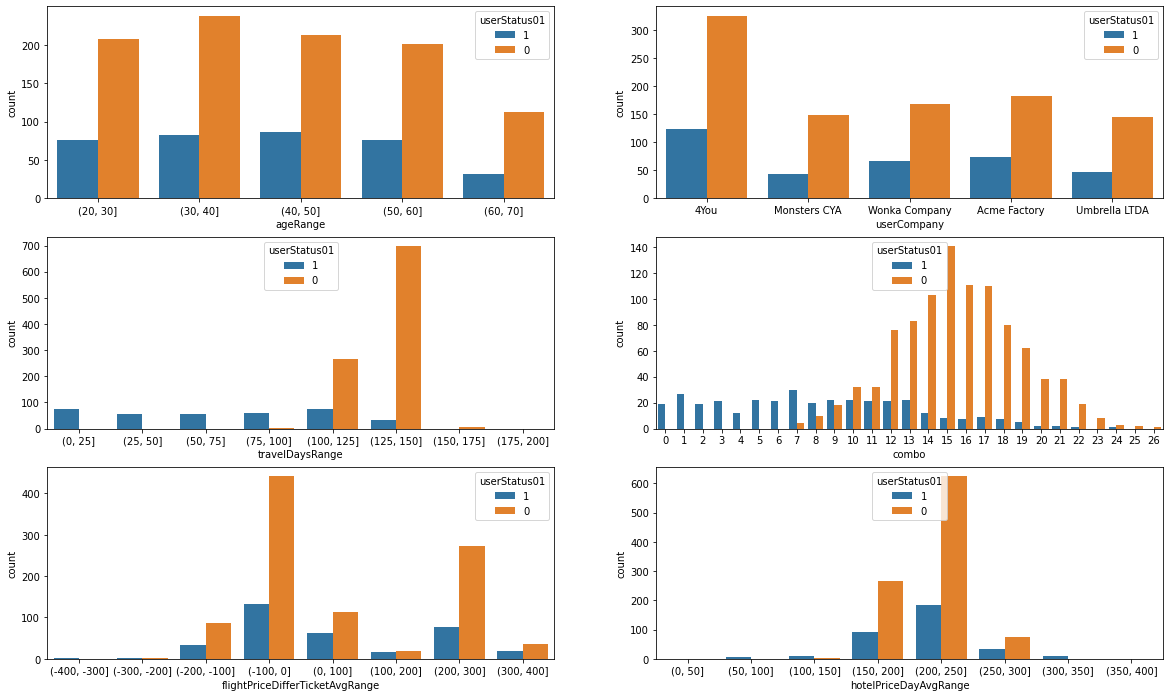

In [51]:
fig, axarr = plt.subplots(3,2, figsize=(20,12))
sns.countplot(x='ageRange', hue = "userStatus01", data = df_customer, 
              hue_order = [1,0], ax=axarr[0][0] )
sns.countplot(x='userCompany', hue = "userStatus01", data = df_customer,
              hue_order = [1,0], ax=axarr[0][1] )
sns.countplot(x='combo', hue = "userStatus01", data = df_customer,
              hue_order = [1,0], ax=axarr[1][1] )
sns.countplot(x='travelDaysRange', hue = "userStatus01", data = df_customer,
              hue_order = [1,0], ax=axarr[1][0] )
sns.countplot(x='flightPriceDifferTicketAvgRange', hue = "userStatus01", data = df_customer, 
              hue_order = [1,0], ax=axarr[2][0] )
sns.countplot(x='hotelPriceDayAvgRange', hue = "userStatus01", data = df_customer,
              hue_order = [1,0], ax=axarr[2][1] )

We take six features and observe if the distribution of churned versus continued customer.  
'userStatus 1' (blue) is the users who haven't book the in the second year.  
'userStatus 0' (orange) is the users who booked in the first and second year.

- ageRange  
The ratio of age range has the same trend for churned and continued cusotmers that the elderly (who is above 60) is a smaller group. As for the continued customer, the age range between 30-40 seems to have a bit more loyalty for the travel agency. Overall, age range might not be the core problem for the travel agency, but if they can be more elderly friendly, for example, optimize the online booking process to make it easier for elderly, it would be an opportunity for acquiring customers.
- userCompany  
We have known that '4You' is the most profitable partner with the travel agency in the section 'check df_flight'. However, each company has around 30% churn rate which means that even the '4You' brings more but losts more.
- travelDaysRange  
The continued user's total travel day is extremely high for more than 100 days. This group of users might have VIP discount and service with the travel agency. As for the churned group, most of them travelled less than 100 days.
- flightPriceDifferTicketAvgRange
The index calcualtes the price difference between Go-ticket and Return-ticket. The continued customers are more than 400 people if the tickets price have no fluctuation (-100<x≤0). Or, if the Return-ticket is cheaper than Go-ticket (200<x≤300), the people might feel they have good deal. However, generally. 
- combo  
Flight + hotel combo is a plus as showed in the figure. If the combo count is less than 9 times than the users churn with higher chance. However, this cannot explain as the "cause" of churn customer becuase the index is also related with how often the users travel.
- hotelPriceDayAvgRange  
Even though the hotel price per day in the range of 200 and 250 is a popular option, the overall churn rate in each price range is 25%. Thus, this might not be the main reason.



[RETURN TO TOP](#Z)

### Undersampling
<a id="c3"></a>
For a small dataset within two thousands records, oversampling is actually a better choice to increase the variety of data. However, since the notebook is emphasized on data visualization techniques, less data points can draw more efficiently so I applied undersampling.

In [52]:
df_customer.groupby('userStatus').size()

userStatus
churned      353
continued    971
dtype: int64

In [53]:
predictors = ['ticketCount',
'flightPriceGo',
'flightPriceReturn',
'flightDistance',
'travelDays',
'hotelDays',
'hotelPrice',
'combo',
'age',
'flightPriceSum',
'flightPriceDistanceAvg',
'hotelPriceDayAvg',
'flightPriceDiffer',
'flightPriceDifferDistanceAvg',
'flightPriceDifferTicketAvg',
'flightPriceTicketAvg',
'comboFrequency',
'hotelStayDayAvg',
'userCompany'
# 'userStatus',
# 'userName',
# 'gender',
# 'ageRange',
]
outcome = 'userStatus01'
X = pd.get_dummies(df_customer[predictors], prefix='', prefix_sep='')
y = df_customer[outcome]

In [54]:
rus = RandomUnderSampler(random_state=777)
X_res, y_res = rus.fit_resample(X,y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 353, 1: 353})


In [55]:
df_X_res = pd.DataFrame(X_res)
df_y_res = pd.DataFrame(y_res)
df_resample = pd.concat([df_X_res, df_y_res], axis=1)
df_resample.head()

,ticketCount,flightPriceGo,flightPriceReturn,flightDistance,travelDays,hotelDays,hotelPrice,combo,age,flightPriceSum,...,flightPriceDifferTicketAvg,flightPriceTicketAvg,comboFrequency,hotelStayDayAvg,4You,Acme Factory,Monsters CYA,Umbrella LTDA,Wonka Company,userStatus01
0,52,45605.90,47030.95,23429.91,138,40.0,9610.29,17,35,92636.85,...,27.404808,1781.477885,0.326923,2.352941,1,0,0,0,0,0
1,52,48487.37,61988.00,34150.86,131,40.0,7322.55,19,37,110475.37,...,259.627500,2124.526346,0.365385,2.105263,0,0,0,1,0,0
2,52,46097.90,61068.20,34574.63,135,30.0,6590.88,14,62,107166.10,...,287.890385,2060.886538,0.269231,2.142857,0,1,0,0,0,0
3,52,53997.16,64264.10,36401.17,131,53.0,10540.88,21,49,118261.26,...,197.441154,2274.255000,0.403846,2.523810,0,1,0,0,0,0
4,52,45491.15,47217.44,24858.48,132,33.0,7042.69,13,46,92708.59,...,33.197885,1782.857500,0.250000,2.538462,1,0,0,0,0,0


In [56]:
# Check outlier if needed
# df_customer.boxplot(column=['flightPriceDiffer'])
# df_customer.loc[df_customer['flightPriceDiffer'] >= 15000]
# df_customer.boxplot(column=['hotelPriceDayAvg'])

[RETURN TO TOP](#Z)

### Setup Features for Model Training
<a id="c4"></a>

In [57]:
# Tool to copy and paste features
# for i in df_customer.columns:
#     print("'"+i+"',")

In [58]:
predictors = ['ticketCount',
'flightPriceGo',
'flightPriceReturn',
'flightDistance',
'travelDays',
'hotelDays',
'hotelPrice',
'combo',
'age',
'flightPriceSum',
'flightPriceDistanceAvg',
'hotelPriceDayAvg',
'flightPriceDiffer',
'flightPriceDifferDistanceAvg',
'flightPriceDifferTicketAvg',
'flightPriceTicketAvg',
'comboFrequency',
'hotelStayDayAvg',
'4You',
'Acme Factory',
'Monsters CYA',
'Umbrella LTDA',
'Wonka Company']
outcome = 'userStatus01'
X = df_resample[predictors]
y = df_resample[outcome]

[RETURN TO TOP](#Z)

### Model I - Naive Bayes
<a id="c5"></a>

In [59]:
# GaussianNB for numerical data
# Delete categorical features
cat_col = ['4You','Acme Factory','Monsters CYA','Umbrella LTDA','Wonka Company']
num_col = list(set(X.columns.tolist())-set(cat_col))
X_NB = df_resample[num_col]

naive_model = GaussianNB()
naive_model.fit(X, y)

GaussianNB()

In [60]:
pred = naive_model.predict(X)
pred_y = naive_model.predict(X) == 1
true_y = y == 1
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat_NB = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = churned', 'Y = continued'],
                       columns=['Y^ = churned', 'Y^ = continued'])
print(conf_mat_NB)

               Y^ = churned  Y^ = continued
Y = churned             302              51
Y = continued             0             353


[RETURN TO TOP](#Z)

### Model II - XGB
<a id="c6"></a>

In [61]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 1)
train_dm = xgb.DMatrix(data=x_train, label=y_train)
valid_dm = xgb.DMatrix(data=x_valid, label=y_valid)

params ={ 'booster':'gbtree',
         'binary':'logistic',   
         'eval_metric': 'auc', #'rmse'
         'max_depth': 5,
         'min_child_weight':20, 
         'gamma':0, 
         'subsample':0.8,
         'colsample_bytree':0.8,
         'eta':0.01,  
         'random_state':7,
         'silent':0 
        }

evallist = [(train_dm,'train'), (valid_dm,'eval')]
# evals_result = {}

# xgb_model = xgb.train(params, train_dm, num_boost_round=100, evals=evallist, early_stopping_rounds=50, evals_result=evals_result)
xgb_model = xgb.train(params, train_dm, num_boost_round=100)

[12:04:44] WARNING: ../src/learner.cc:576: 
Parameters: { "binary", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [62]:
x_test = df_resample[df_resample['userStatus01']==1][predictors]
test_dm = xgb.DMatrix(data = x_test)
y_pred = xgb_model.predict(test_dm)
np.count_nonzero(y_pred > 0.5)

343

In [63]:
x_test = df_resample[df_resample['userStatus01']==0][predictors]
test_dm = xgb.DMatrix(data = x_test)

y_pred = xgb_model.predict(test_dm)
np.count_nonzero(y_pred < 0.5)

353

In [64]:
pred = xgb_model.predict(xgb.DMatrix(data = df_resample[predictors]))

In [65]:
# Confusion matrix
pred = xgb_model.predict(xgb.DMatrix(data = df_resample[predictors]))
pred_y = pred >= 0.5
true_y = y == 1
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat_XGB = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = churned', 'Y = continued'],
                       columns=['Y^ = churned', 'Y^ = continued'])
print(conf_mat_XGB)
conf_mat_XGB = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]])

               Y^ = churned  Y^ = continued
Y = churned             343              10
Y = continued             0             353


[RETURN TO TOP](#Z)

### Scatterplot Matrix for Significant Features
<a id="c7"></a>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

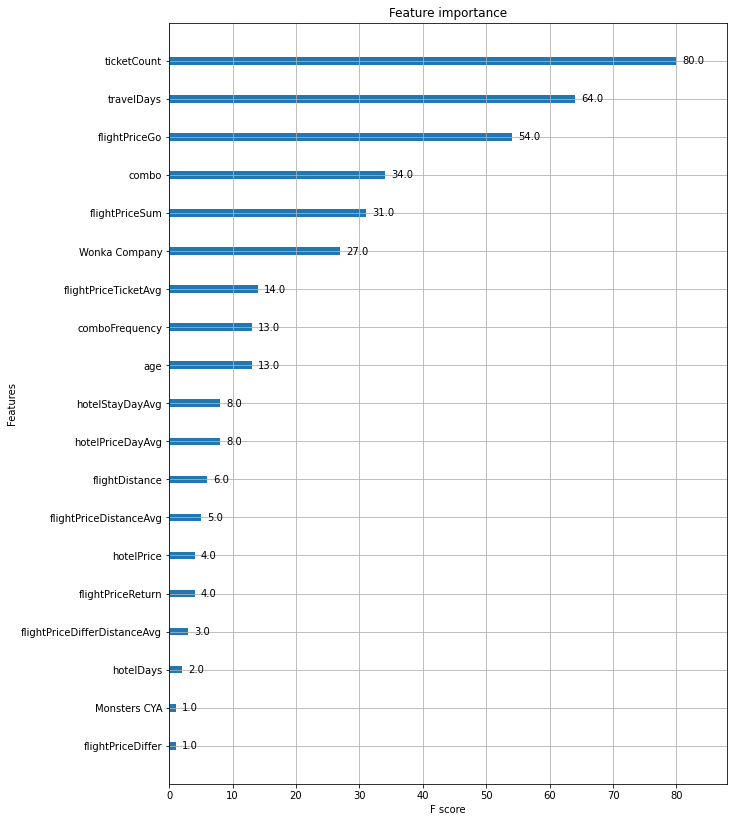

In [66]:
plot_features(xgb_model, (10,14))

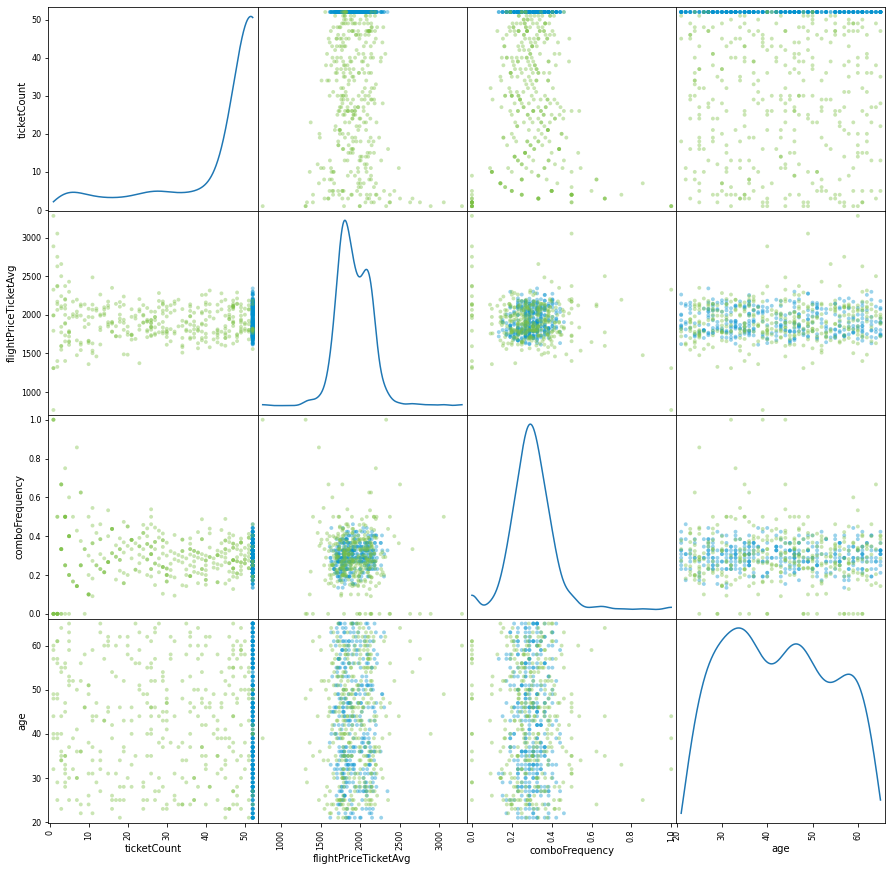

In [67]:
X = df_resample[['ticketCount','flightPriceTicketAvg', 'comboFrequency', 'age']]
y = df_resample['userStatus01']
# cmap = cm.get_cmap('BuPu')  cmap = cmap
color_wheel = {1: "#0392cf",#CONTINUED #Blue
               2: "#7bc043"#CHURNED # Green
           }

colors = df_resample['userStatus01'].map(lambda x:color_wheel.get(x + 1))                
                
scatter = pd.plotting.scatter_matrix(X, marker = 'm', diagonal='kde' ,s = 15,  figsize = (15,15), color=colors, alpha=0.4)

It's interesting to observe the relationship between two features after selecting the most important features from XGB ('ticketCount','flightPriceTicketAvg', 'comboFrequency', 'age'). Consistently with the finding in the section "Visualize the Distribution of Features" that continued users travel more than 100 days a year, the blue cluster (continued customer) are very densed with the ticket count which is more than 50 times, no matter it is related with average flight price, combo frequency, or age.  
As for the combo frequency (combo times / total travel times), the chruned customer falls in 0% to 100% while the continued customer falls in 20% to 40%. Flight + hotel combo is a necessary service for the continued customer, but it seems to have different feedback for the churned customer. If we look at the relationship between ticketCount and comboFrequency, the green pattern clustered if the combo frenquency is 0%. People without combo experience always churn. For ticket count less than 50 times, even though the combo frequency falls in 20% to 40%, they're still unlikely join the next year. There are also cases that people travelled less but very often with the combo trips, but they still churned in the next year. All in all, combo is a plus for the travellers but it might not be the main factor to determine customer's willingness of booking for the next time.

[RETURN TO TOP](#Z)

### Model III - Logistic Regression
<a id="c8"></a>

In [68]:
logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  147.8188052457293
classes [0 1]


,coeff
ticketCount,-2.873803
flightPriceTicketAvg,-0.000819
comboFrequency,2.183580
age,-0.013514


In [69]:
#logit_reg.predict_log_proba(X)
# the smaller the log the better
logit_reg.predict_proba(X)

array([[9.44620538e-01, 5.53794619e-02],
       [9.55232476e-01, 4.47675242e-02],
       [9.72244350e-01, 2.77556499e-02],
       ...,
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.30638389e-10, 1.00000000e+00]])

In [70]:
a = pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

In [71]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 1
true_y = y == 1
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat_LR = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = churned', 'Y = continued'],
                       columns=['Y^ = churned', 'Y^ = continued'])
print(conf_mat_LR)

               Y^ = churned  Y^ = continued
Y = churned             336              17
Y = continued             0             353


[RETURN TO TOP](#Z)

### Regression Plot for Possible Factors
<a id="c9"></a>
Select the top variables with the absolute maximum coefficient.  
flightPriceTicketAvg (coef = 0.149401)  
combo (coef = -0.005647)  
hotelPriceDayAvg (coef = -0.004060)

In [72]:
# Reversed dummy variables to categorical variables
df_corr = df_resample
df_userCompany = df_resample[['4You','Acme Factory','Monsters CYA','Umbrella LTDA','Wonka Company']]
df_corr['4You'] = df_corr['4You'].replace({1: 1, 0:0})
df_corr['Acme Factory'] = df_corr['Acme Factory'].replace({1: 2, 0:0})
df_corr['Monsters CYA'] = df_corr['Monsters CYA'].replace({1: 3, 0:0})
df_corr['Umbrella LTDA'] = df_corr['Umbrella LTDA'].replace({1: 4, 0:0})
df_corr['Wonka Company'] = df_corr['Wonka Company'].replace({1: 5, 0:0})
df_corr['userCompany'] = df_corr['4You']+df_corr['Acme Factory'] +df_corr['Monsters CYA'] +df_corr['Umbrella LTDA'] + df_corr['Wonka Company']

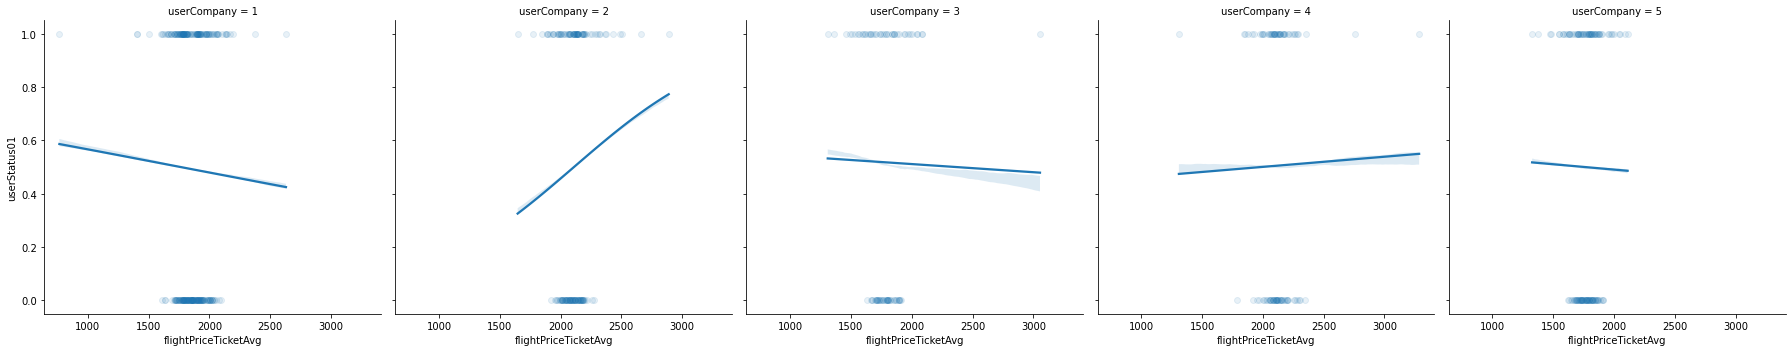

In [73]:
sns.lmplot(x='flightPriceTicketAvg', y ='userStatus01', data = df_resample,col='userCompany', 
           palette='OrRd',
           x_jitter = False,  y_jitter =False, ci = 5,
           scatter_kws={'alpha':0.1}, truncate = True, logistic = True)

The five companies have different flight tickt price strategies. For company 1&3&5, the cheaper the ticket is the higher customer retention is. As for company 2&4, the customers buy in the tiekets higher than average price ($2000). If the flight tickt fluctuated more, it might lose some customers.

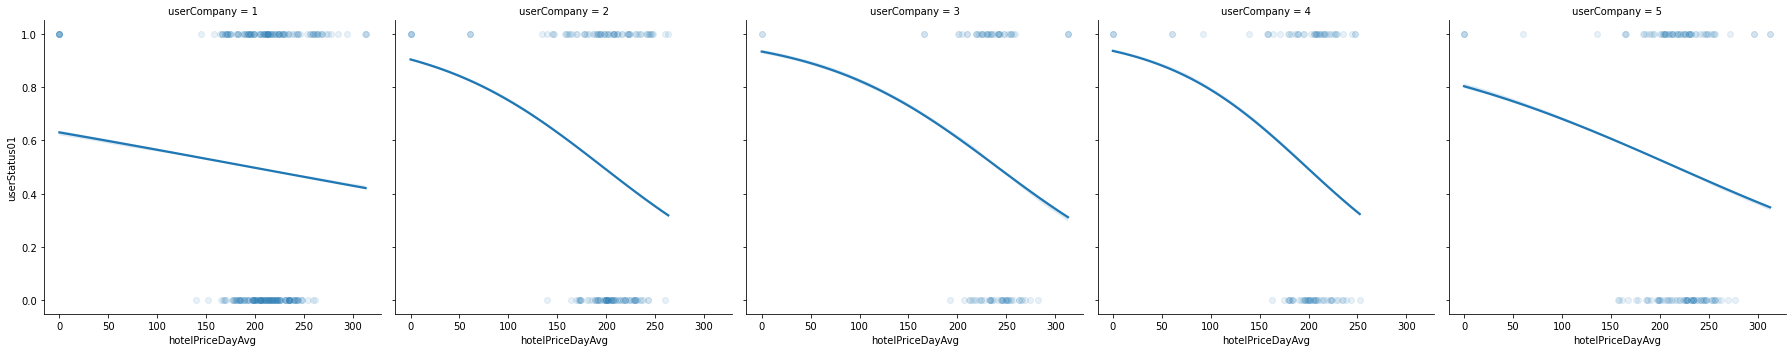

In [74]:
sns.lmplot(x='hotelPriceDayAvg', y ='userStatus01', data = df_resample,col='userCompany', 
           x_jitter = False,  y_jitter =False, ci = 5,
           scatter_kws={'alpha':0.1}, truncate = True, logistic = True)

As for the hotel price, the companies prefer the price range around 200. If the hotel price is not stable (ranged from $0 to 300), it might lose some customers.

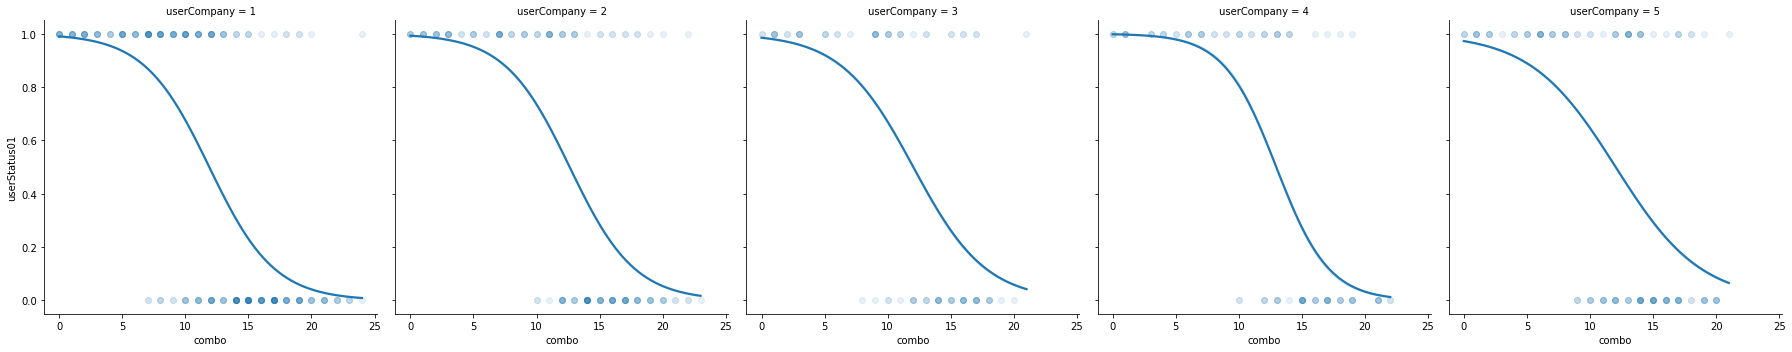

In [75]:
sns.lmplot(x='combo', y ='userStatus01', data = df_resample, col='userCompany', 
           x_jitter = False,  y_jitter =False, ci = 5,
           scatter_kws={'alpha':0.1}, truncate = True, logistic = True)

Combo frequency hasn't influeced by different companies. Combo frequency within 10-20 times have the best retention rate.

[RETURN TO TOP](#Z)

### Compare the Prediction Result of Models
<a id="c10"></a>
For the synthetic dataset, the model has stunning 100% precision. XGB model has closely 97% recall which performs the best among the models.

In [76]:
conf_mat_NB = conf_mat_NB.to_numpy()
print('Precision', conf_mat_NB[0, 0] / sum(conf_mat_NB[:, 0]))
print('Recall', conf_mat_NB[0, 0] / sum(conf_mat_NB[0, :]))
print('Specificity', conf_mat_NB[1, 1] / sum(conf_mat_NB[1, :]))

Precision 1.0
Recall 0.8555240793201133
Specificity 1.0


In [77]:
conf_mat_XGB = conf_mat_XGB.to_numpy()
print('Precision', conf_mat_XGB[0, 0] / sum(conf_mat_XGB[:, 0]))
print('Recall', conf_mat_XGB[0, 0] / sum(conf_mat_XGB[0, :]))
print('Specificity', conf_mat_XGB[1, 1] / sum(conf_mat_XGB[1, :]))

Precision 1.0
Recall 0.9716713881019831
Specificity 1.0


In [78]:
conf_mat_LR = conf_mat_LR.to_numpy()
print('Precision', conf_mat_LR[0, 0] / sum(conf_mat_LR[:, 0]))
print('Recall', conf_mat_LR[0, 0] / sum(conf_mat_LR[0, :]))
print('Specificity', conf_mat_LR[1, 1] / sum(conf_mat_LR[1, :]))

Precision 1.0
Recall 0.9518413597733711
Specificity 1.0


[RETURN TO TOP](#Z)

After the whole analysis process, we're able to further explain the customer behaviors.  

Why did Group B (2020-2021) has lower revenue each month, comparing to Group A (2019-2020)?
> The biggist problem the travel agency faces is that there is no new customer since 2019, thus the business is shrinking.

What's the percentage of new customers? 
> 0%  
Refer to  [Transform from Order Dimension to Customer Dimension](#b3)  

How did the customers travel? Did they book hotel with flights? Did they unsatisified with the services?
> Customer retention is the highest when they booked 20%-40% combo trips.  
Refer to [Scatterplot Matrix for Significant Features](#c7)

Which features are most related to customer retention? Which group of customers decided not to travel first?
> Only the customers who travelled more than 100 times a year would book their next trip in 2021.  
Refer to [Visualize the Distribution of Features](#c2)

#### Upvote if you like the methods in the analysis !